# Magnification factor of $\beta$-VAE toy example
[Yusuke Hayashi](https://github.com/hayashiyus)<br/>
April 30, 2024 <br/>

## Variational inference
Given samples $x$ from an unobserved data density $q(x)$, we are interested in building a latent-variable generative model $p_{\varphi}(x, z)$ such that $p(x)$ is close to $q(x)$. This is a difficult problem as evaluating the density under the model, $p(x)$ requires evaluating an intractable integral over the unobserved latent variable $z$: $p_{\varphi}(x)=\int \mathrm{d}z \;p_{\varphi}(x, z)$.
$$
\begin{gathered}
q_\phi(x, z) = q(x) q_\phi(z \mid x) \\
p_{\varphi}(x, z) = p(z) p_{\varphi}(x \mid z)
\end{gathered}
$$
The variational principle bypasses this problem by optimizing a lower bound on the log-likelihood of the data. In this case, the objective $\mathcal{L}_{\mathrm{VAE-ELBO}}$:
$$
\begin{aligned}
\mathbb{E}_{q(x)}\left[\log p_{\varphi}(x)\right] & =\mathbb{E}_{q(x)}\left[\log \int p_{\varphi}(x, \psi) d \psi\right] \\
& =\mathbb{E}_{q(x)}\left[\log \int q_\phi(\psi \mid x) \frac{p_{\varphi}(x, \psi)}{q_\phi(\psi \mid x)} d \psi\right] \\
& \geq \mathbb{E}_{q(x)}\left[\int q_\phi(\psi \mid x) \log \frac{p_{\varphi}(x, \psi)}{q_\phi(\psi \mid x)} d \psi\right] \\
& =\mathbb{E}_{q_\phi(x, \psi)}\left[\log p_{\varphi}(x \mid \psi)\right]-\mathbb{E}_{q(x)}\left[D_{\mathrm{KL}}\left(q_\phi(\psi \mid x) \| p(\psi)\right)\right] := \mathcal{L}_{\mathrm{VAE-ELBO}}
\end{aligned}
$$
The objective of $\beta$-VAE $\mathcal{L}_{\beta-\mathrm{VAE}}$ is given as a slight modification of the ELBO of VAE:
$$
\mathcal{L}_{\beta-\mathrm{VAE}} := \mathbb{E}_{q_\phi(x, z)}\left[\log p_{\varphi}(x \mid z)\right]-\frac{1}{\beta} \mathbb{E}_{q(x)}\left[D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p(z)\right)\right]
$$
The objective of $\beta$-VAE $\mathcal{L}_{\beta-\mathrm{VAE}}$ can be derived according to the variational principle by modifying the respective encoder and decoder models as follows:
$$
\begin{aligned}
& q_{\beta, \phi}(x, z)=\frac{q^\beta(x) q_\phi(z \mid x)}{Z_q(\beta)} . \\
& p_{\beta, \varphi}(x, z)=\frac{p(z) p_{\varphi}^\beta(x \mid z)}{Z_p(\beta)} .
\end{aligned}
$$
$$
\begin{aligned}
\mathcal{L}_{\mathrm{Neq-VAE}} &:= \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log p_{\varphi}(x \mid z)\right]-\frac{1}{\beta} \mathbb{E}_{q^\beta(x)}\left[D_{\mathrm{KL}}\left(q_\phi(z \mid x) \| p(z)\right)\right]
\end{aligned}
$$
$$
\begin{aligned}
-\frac{1}{\beta} D_{\mathrm{KL}}\left(q_{\beta, \phi}(x, z) \| p_{\beta, \varphi}(x, z)\right) & =-\frac{1}{\beta} \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log \frac{q_{\beta, \phi}(x, z)}{p_{\beta, \varphi}(x, z)}\right] \\
& =-\frac{1}{\beta} \mathbb{E}_{q_{\beta, \phi}(x, z)}\left[\log \frac{Z_p(\beta) q^\beta(x) q_\phi(z \mid x)}{Z_q(\beta) p(z) p_{\varphi}^\beta(x \mid z)}\right] \\
& =\frac{1}{\beta}\left(-\log \frac{Z_p(\beta)}{Z_q(\beta)}+H_{q_\phi^\beta}(x)\right)+\mathcal{L}_{\text{Neq-VAE}} \\
& \geq \frac{1}{\beta}\left(-\log \frac{Z_p(\beta)}{Z_q(\beta)}+H_{q_\phi^\beta}(x)\right)+\mathcal{L}_{\beta-\mathrm{VAE}} .
\end{aligned}
$$

This lower bound depends on an additional distribution, $q(z|x)$ which is known as the _variational distribution_ and acts as an approximation to the true posterior $p(z|x)$. 
To evaluate and learn using the variational lower bound, we need to be able to draw samples from the _variational distribution_ and to evaluate the density of a sample from the _variational distribution_. This typically restricts the family of variational distributions to those with known or tractable densities (e.g. factorial Gaussian, normalizing flows).

Send questions/comments/bugs to [@hayashiyus](https://twitter.com/hayashiyus).

## Create dataset of one-hot vectors

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli
from torch.utils.data import DataLoader, TensorDataset
from sklearn import datasets
import sklearn.preprocessing as sp
import sklearn.model_selection as sm
import matplotlib
import mplcyberpunk
import matplotlib.cm as cm
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

plt.style.use("cyberpunk")

# Load training datasets
MNIST = datasets.load_digits()
X = MNIST.data  # X: images
X = X / 16  # Normalize pixel values
yl = MNIST.target  # yl: labels
D, n = X.shape

n_im_row, n_im_col = 5, 15
n_im = n_im_row * n_im_col
d = np.arange(D)
d_choice = np.random.choice(np.arange(D), n_im, replace=False)

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

# Split the dataset into train and test datasets
X_train, X_test, yl_train, yl_test = sm.train_test_split(X, yl, train_size=1/2, test_size=1/2)

X_test = X_test[:-1]
yl_test = yl_test[:-1]

# create dataset of one-hot vectors
# class size
C = 10                      
# .A means 'change the data type from a matrix to an array'
enc = sp.OneHotEncoder()
Y_train = enc.fit_transform(yl_train.reshape(-1, 1)).A
Y_test = enc.fit_transform(yl_test.reshape(-1, 1)).A

print('訓練データ数：D_train =', len(Y_train))
print('テストデータ数：D_test =', len(Y_test))

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

訓練データ数：D_train = 898
テストデータ数：D_test = 898


## Setup

In [2]:
# Constants
n_epoch = 100000 + 1
batch_size = X_train.shape[0]
latent_dim = 2  # Assuming latent_dim is 2 for this example
n_layer = 4  # Assuming n_layer is 4 for this example
n_unit = 258  # Assuming n_unit is 256 for this example
output_dim = Y_train.shape[1]  # Assuming output_dim is the number of classes

# Data
x = torch.tensor(X_train, dtype=torch.float32)
y = torch.tensor(Y_train, dtype=torch.float32)

# データセットの準備
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Encoder network
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_layers = nn.Sequential(*[nn.Linear(hidden_dim if i > 0 else input_dim, hidden_dim) for i in range(n_layer)])
        self.loc = nn.Linear(hidden_dim, latent_dim)
        self.scale = nn.Linear(hidden_dim, latent_dim)
        self.softplus = nn.Softplus()
        self.mish = nn.Mish()
    
    def forward(self, x):
        enc = self.fc_layers(x)
        loc = self.mish(self.loc(enc))
        scale = 1e-6 + (1 - 2e-6) * self.softplus(self.scale(enc))
        return loc, scale

# Decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_layers = nn.Sequential(*[nn.Linear(hidden_dim if i > 0 else latent_dim, hidden_dim) for i in range(n_layer)])
        self.dec = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z):
        dec = self.fc_layers(z)
        dec = 1e-6 + (1 - 2e-6) * self.sigmoid(self.dec(dec))
        return dec

# Instantiate networks
encoder = Encoder(input_dim=x.shape[1], hidden_dim=n_unit, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=n_unit, output_dim=output_dim)
encoder_params = dict(encoder.named_parameters())
decoder_params = dict(decoder.named_parameters())

/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_37886/3462808256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X_train, dtype=torch.float32)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_37886/3462808256.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(Y_train, dtype=torch.float32)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_37886/3462808256.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tens

In [3]:
def compute_jacobian(model, params, input):
    func = torch.func.functional_call(model, params, input)
    output_dim = func.shape[1]
    #J = [torch.autograd.grad(outputs=func[:, i], inputs=input, grad_outputs=torch.ones_like(func[:, i]), allow_unused=True, retain_graph=True, create_graph=True)[0] for i in range(output_dim)]
    J = [torch.autograd.grad(outputs=func[:, i], inputs=input, grad_outputs=func[:, i], allow_unused=True, retain_graph=True, create_graph=False)[0] for i in range(output_dim)]
    J = torch.stack(J, dim=1)  # batch x output x latent
    return J

def compute_logprobs(model, params, input, cyclical_beta, j):
    func = torch.func.functional_call(model, params, input)
    log_probs = Bernoulli(probs=func.pow_(cyclical_beta[j])).log_prob(y)
    output_dim = func.shape[1]
    #J = [torch.autograd.grad(outputs=log_probs[:, i], inputs=input, grad_outputs=torch.ones_like(log_probs[:, i]), allow_unused=True, retain_graph=True, create_graph=True)[0] for i in range(output_dim)]
    J = [torch.autograd.grad(outputs=log_probs[:, i], inputs=input, grad_outputs=log_probs[:, i], allow_unused=True, retain_graph=True, create_graph=False)[0] for i in range(output_dim)]
    J = torch.stack(J, dim=1)  # batch x output x latent
    return J

def compute_magnification_factor(J):
    """
    creates the metric tensor (J^T J and J being the jacobian of the decoder), 
    which can be evaluated at any point in Z
    and
    the magnification factor
    """
    G = torch.matmul(J.permute(0, 2, 1), J)  # J^T \cdot J
    # magnification factor
    mf = torch.sqrt(torch.det(G))
    return mf

def compute_fisher_information_factor(J):
    """
    Computes the Fisher Information Factor using the Jacobian matrix.
    
    Args:
    - jacobian (torch.Tensor): The Jacobian matrix. Shape: [batch_size, output_dim, input_dim].
    
    Returns:
    - fif (torch.Tensor): The Fisher Information Factor. Shape: [batch_size].
    """
    G = torch.matmul(J.permute(0, 2, 1), J)  # J^T \cdot J
    # fisher information factor
    fif = torch.diagonal(G, dim1=1, dim2=2).sum(dim=1)
    return fif

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    tiled_x = x.view(x_size, 1, dim).expand(x_size, y_size, dim)
    tiled_y = y.view(1, y_size, dim).expand(x_size, y_size, dim)
    return torch.exp(-torch.mean((tiled_x - tiled_y) ** 2, dim=2) / dim)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)

  0%|          | 0/100001 [00:00<?, ?it/s]

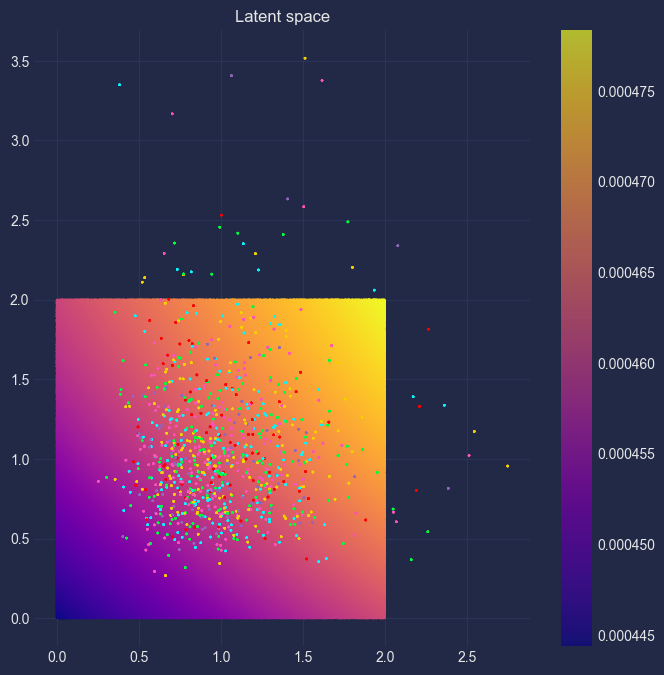

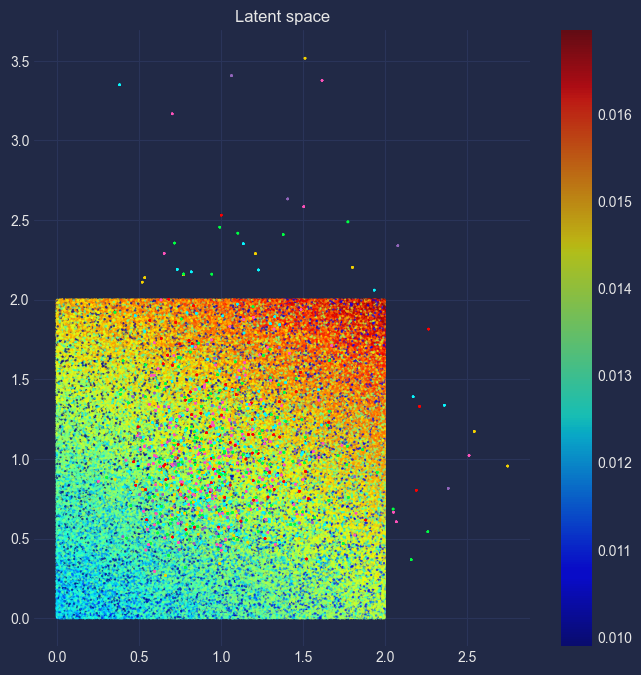

  0%|          | 12/100001 [00:22<37:17:32,  1.34s/it]

    0:(beta)=(    0.8000)


  1%|          | 1018/100001 [00:31<15:09, 108.78it/s]

 1000:(beta)=(    0.6082)


  2%|▏         | 2014/100001 [00:40<15:03, 108.50it/s]

 2000:(beta)=(    0.6912)


  3%|▎         | 3022/100001 [00:49<14:23, 112.35it/s]

 3000:(beta)=(    0.9301)


  4%|▍         | 4023/100001 [00:58<14:29, 110.34it/s]

 4000:(beta)=(    0.9826)


  5%|▌         | 5020/100001 [01:08<14:21, 110.28it/s]

 5000:(beta)=(    0.7735)


  6%|▌         | 6019/100001 [01:17<13:54, 112.65it/s]

 6000:(beta)=(    0.6024)


  7%|▋         | 7014/100001 [01:26<13:56, 111.14it/s]

 7000:(beta)=(    0.7144)


  8%|▊         | 8021/100001 [01:35<13:45, 111.44it/s]

 8000:(beta)=(    0.9491)


  9%|▉         | 9017/100001 [01:44<13:30, 112.22it/s]

 9000:(beta)=(    0.9701)


 10%|▉         | 9998/100001 [02:10<13:42, 109.44it/s]

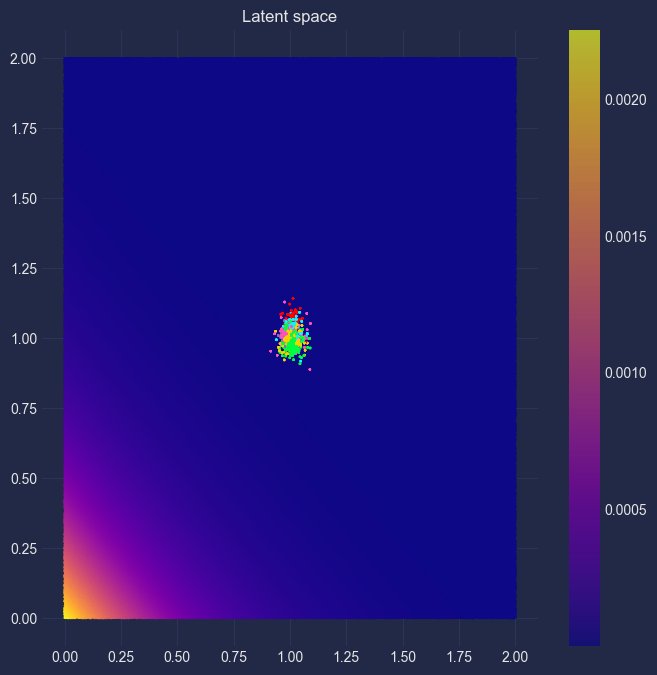

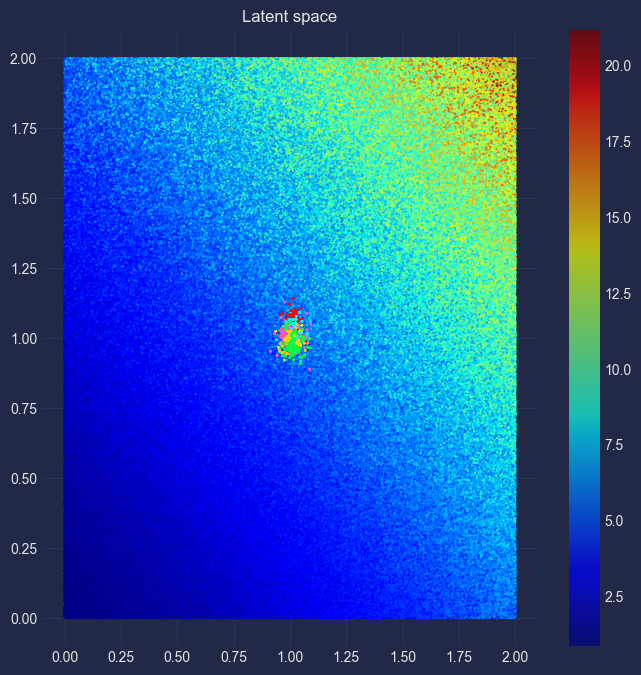

 10%|█         | 10012/100001 [02:14<12:08:31,  2.06it/s]

10000:(beta)=(    0.7474)


 11%|█         | 11020/100001 [02:23<13:10, 112.52it/s]  

11000:(beta)=(    0.6000)


 12%|█▏        | 12016/100001 [02:32<12:56, 113.30it/s]

12000:(beta)=(    0.7392)


 13%|█▎        | 13024/100001 [02:41<12:45, 113.67it/s]

13000:(beta)=(    0.9654)


 14%|█▍        | 14010/100001 [02:50<13:04, 109.65it/s]

14000:(beta)=(    0.9547)


 15%|█▌        | 15013/100001 [03:00<13:00, 108.82it/s]

15000:(beta)=(    0.7223)


 16%|█▌        | 16023/100001 [03:09<12:27, 112.39it/s]

16000:(beta)=(    0.6012)


 17%|█▋        | 17017/100001 [03:18<12:23, 111.58it/s]

17000:(beta)=(    0.7650)


 18%|█▊        | 18016/100001 [03:27<12:06, 112.82it/s]

18000:(beta)=(    0.9789)


 19%|█▉        | 19015/100001 [03:36<11:45, 114.78it/s]

19000:(beta)=(    0.9365)


 20%|█▉        | 19991/100001 [04:00<11:39, 114.40it/s]

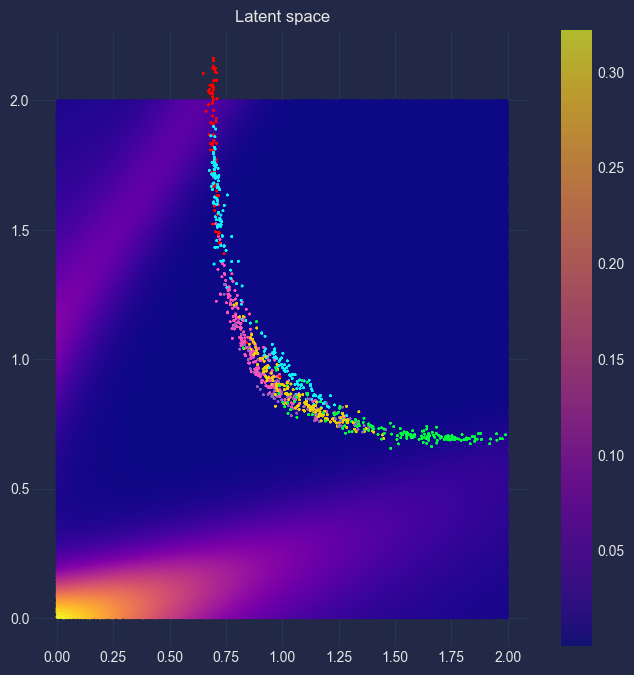

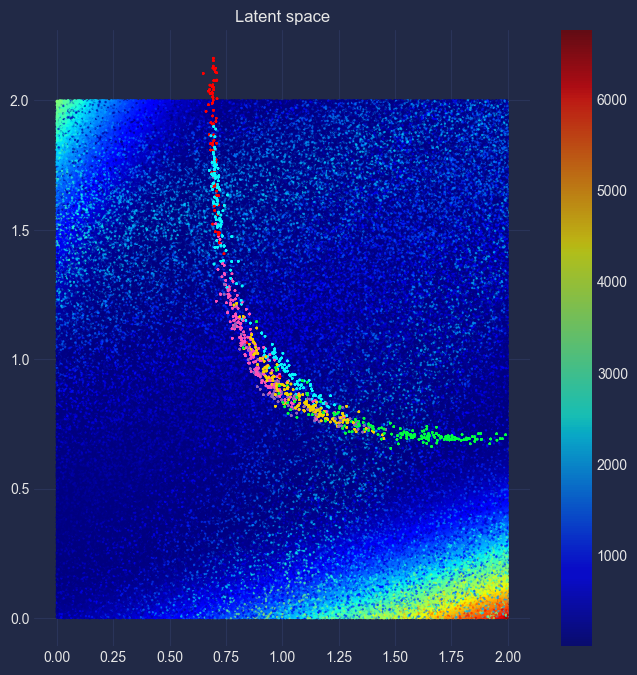

 20%|██        | 20013/100001 [04:07<9:04:29,  2.45it/s] 

20000:(beta)=(    0.6986)


 21%|██        | 21024/100001 [04:16<10:47, 121.93it/s] 

21000:(beta)=(    0.6059)


 22%|██▏       | 22016/100001 [04:24<11:26, 113.52it/s]

22000:(beta)=(    0.7914)


 23%|██▎       | 23021/100001 [04:33<11:35, 110.68it/s]

23000:(beta)=(    0.9892)


 24%|██▍       | 24022/100001 [04:41<10:45, 117.70it/s]

24000:(beta)=(    0.9159)


 25%|██▌       | 25015/100001 [04:50<10:34, 118.23it/s]

25000:(beta)=(    0.6766)


 26%|██▌       | 26015/100001 [04:58<10:30, 117.36it/s]

26000:(beta)=(    0.6141)


 27%|██▋       | 27017/100001 [05:07<10:59, 110.71it/s]

27000:(beta)=(    0.8179)


 28%|██▊       | 28019/100001 [05:15<10:17, 116.61it/s]

28000:(beta)=(    0.9961)


 29%|██▉       | 29023/100001 [05:24<09:55, 119.13it/s]

29000:(beta)=(    0.8933)


 30%|██▉       | 29995/100001 [05:50<10:31, 110.79it/s]

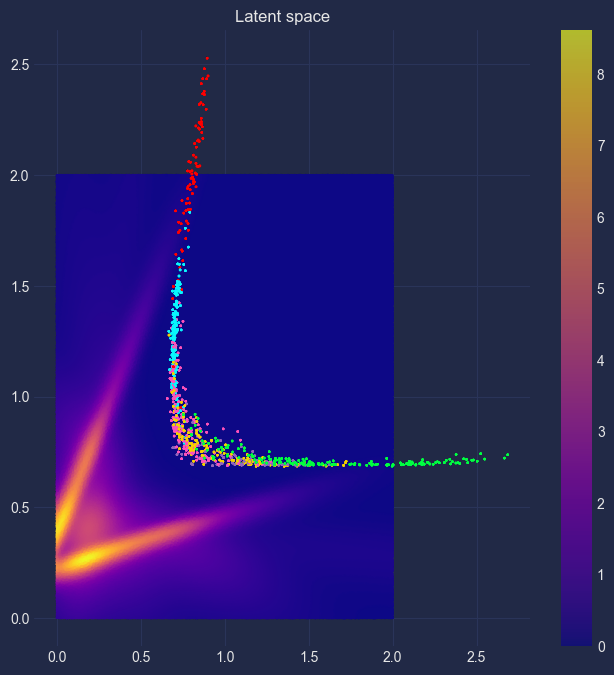

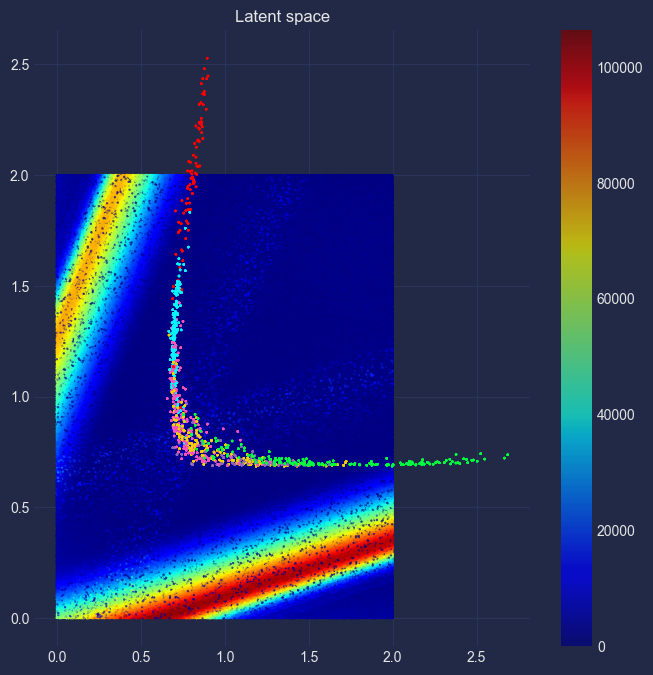

 30%|███       | 30012/100001 [05:55<9:07:25,  2.13it/s] 

30000:(beta)=(    0.6568)


 31%|███       | 31023/100001 [06:04<10:17, 111.74it/s] 

31000:(beta)=(    0.6255)


 32%|███▏      | 32015/100001 [06:14<10:55, 103.69it/s]

32000:(beta)=(    0.8442)


 33%|███▎      | 33018/100001 [06:23<10:02, 111.26it/s]

33000:(beta)=(    0.9996)


 34%|███▍      | 34021/100001 [06:32<09:37, 114.29it/s]

34000:(beta)=(    0.8690)


 35%|███▌      | 35020/100001 [06:41<09:31, 113.71it/s]

35000:(beta)=(    0.6396)


 36%|███▌      | 36018/100001 [06:50<10:02, 106.22it/s]

36000:(beta)=(    0.6400)


 37%|███▋      | 37016/100001 [06:59<09:25, 111.45it/s]

37000:(beta)=(    0.8697)


 38%|███▊      | 38023/100001 [07:09<09:16, 111.39it/s]

38000:(beta)=(    0.9995)


 39%|███▉      | 39012/100001 [07:18<09:11, 110.65it/s]

39000:(beta)=(    0.8435)


 40%|███▉      | 39999/100001 [07:40<08:45, 114.17it/s]

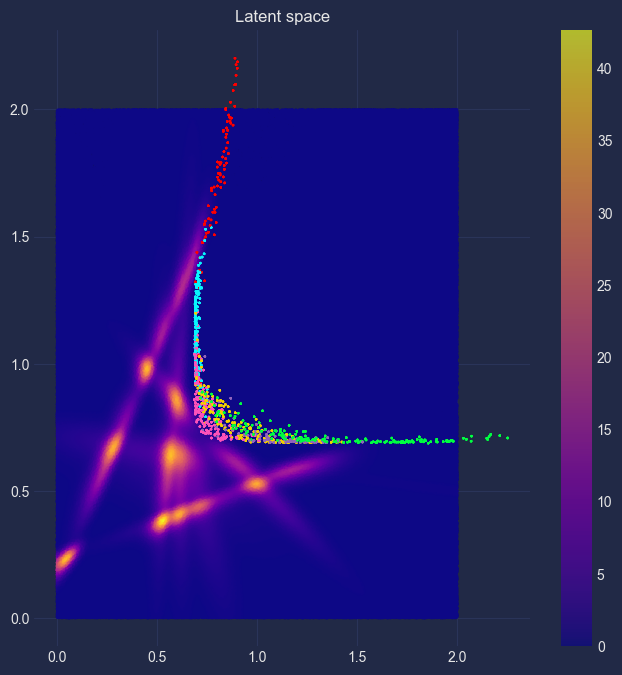

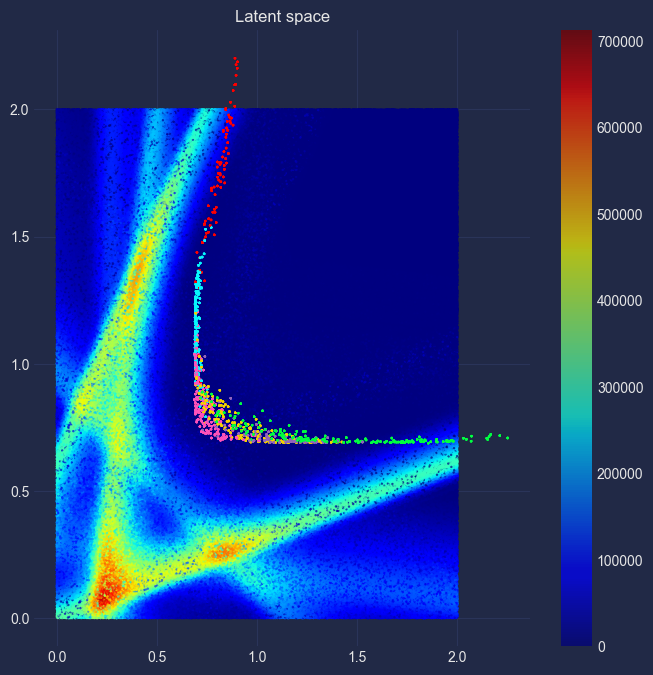

 40%|████      | 40012/100001 [07:49<8:12:42,  2.03it/s] 

40000:(beta)=(    0.6251)


 41%|████      | 41017/100001 [07:58<08:27, 116.23it/s] 

41000:(beta)=(    0.6573)


 42%|████▏     | 42022/100001 [08:06<08:09, 118.35it/s]

42000:(beta)=(    0.8939)


 43%|████▎     | 43014/100001 [08:15<07:55, 119.85it/s]

43000:(beta)=(    0.9960)


 44%|████▍     | 44016/100001 [08:23<07:52, 118.47it/s]

44000:(beta)=(    0.8172)


 45%|████▌     | 45013/100001 [08:32<07:58, 114.90it/s]

45000:(beta)=(    0.6138)


 46%|████▌     | 46017/100001 [08:42<08:38, 104.21it/s]

46000:(beta)=(    0.6771)


 47%|████▋     | 47019/100001 [08:51<07:41, 114.91it/s]

47000:(beta)=(    0.9165)


 48%|████▊     | 48022/100001 [09:00<07:42, 112.49it/s]

48000:(beta)=(    0.9889)


 49%|████▉     | 49015/100001 [09:09<08:24, 101.08it/s]

49000:(beta)=(    0.7907)


 50%|████▉     | 49999/100001 [09:30<07:08, 116.62it/s]

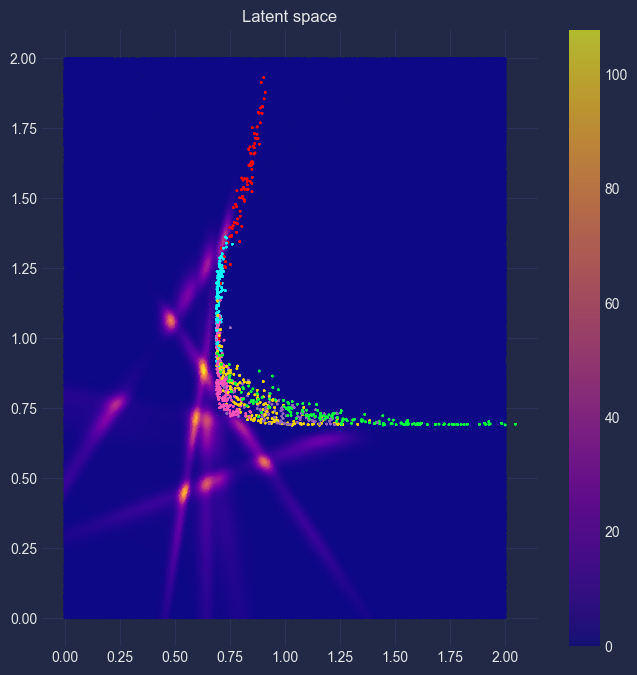

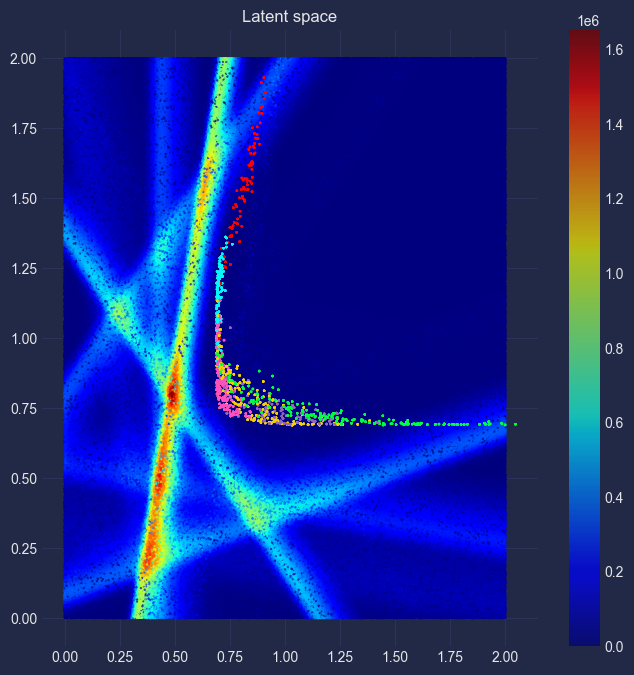

 50%|█████     | 50012/100001 [09:40<6:27:50,  2.15it/s]

50000:(beta)=(    0.6058)


 51%|█████     | 51020/100001 [09:48<06:47, 120.27it/s] 

51000:(beta)=(    0.6992)


 52%|█████▏    | 52015/100001 [09:57<06:53, 115.92it/s]

52000:(beta)=(    0.9370)


 53%|█████▎    | 53020/100001 [10:06<07:05, 110.30it/s]

53000:(beta)=(    0.9786)


 54%|█████▍    | 54021/100001 [10:15<06:33, 116.93it/s]

54000:(beta)=(    0.7643)


 55%|█████▌    | 55016/100001 [10:24<06:25, 116.56it/s]

55000:(beta)=(    0.6012)


 56%|█████▌    | 56020/100001 [10:32<06:14, 117.52it/s]

56000:(beta)=(    0.7230)


 57%|█████▋    | 57013/100001 [10:41<06:05, 117.52it/s]

57000:(beta)=(    0.9551)


 58%|█████▊    | 58011/100001 [10:51<06:46, 103.21it/s]

58000:(beta)=(    0.9650)


 59%|█████▉    | 59020/100001 [11:00<06:20, 107.72it/s]

59000:(beta)=(    0.7385)


 60%|█████▉    | 59991/100001 [11:20<05:45, 115.64it/s]

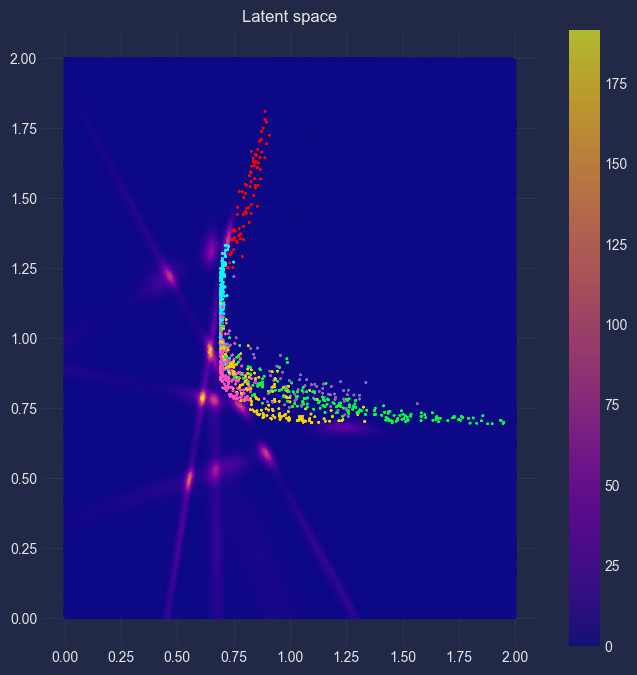

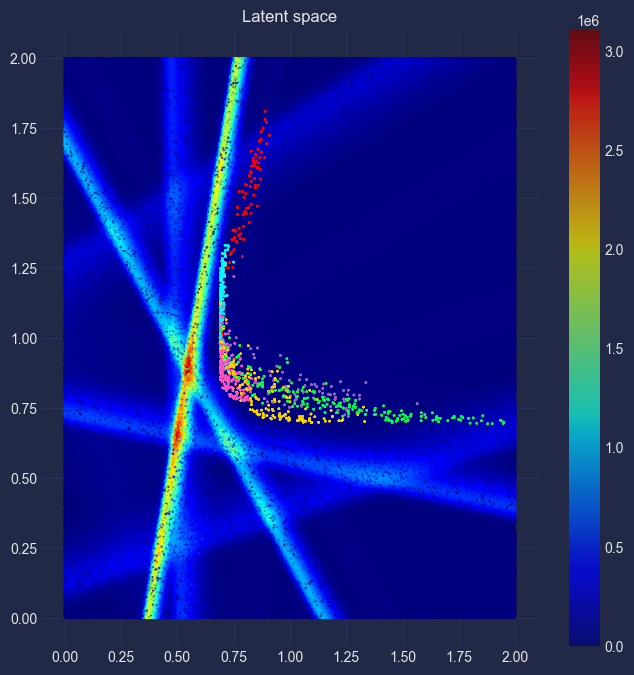

 60%|██████    | 60011/100001 [11:30<4:43:00,  2.36it/s]

60000:(beta)=(    0.6001)


 61%|██████    | 61021/100001 [11:41<06:33, 99.10it/s]  

61000:(beta)=(    0.7481)


 62%|██████▏   | 62016/100001 [11:51<06:39, 95.13it/s]

62000:(beta)=(    0.9705)


 63%|██████▎   | 63012/100001 [12:02<06:26, 95.63it/s]

63000:(beta)=(    0.9486)


 64%|██████▍   | 64013/100001 [12:12<06:10, 97.04it/s] 

64000:(beta)=(    0.7138)


 65%|██████▌   | 65020/100001 [12:23<06:10, 94.44it/s] 

65000:(beta)=(    0.6025)


 66%|██████▌   | 66011/100001 [12:33<05:54, 95.85it/s] 

66000:(beta)=(    0.7742)


 67%|██████▋   | 67019/100001 [12:43<05:36, 98.04it/s]

67000:(beta)=(    0.9829)


 68%|██████▊   | 68016/100001 [12:54<05:32, 96.06it/s]

68000:(beta)=(    0.9295)


 69%|██████▉   | 69016/100001 [13:03<04:47, 107.81it/s]

69000:(beta)=(    0.6906)


 70%|██████▉   | 69991/100001 [13:30<04:34, 109.44it/s]

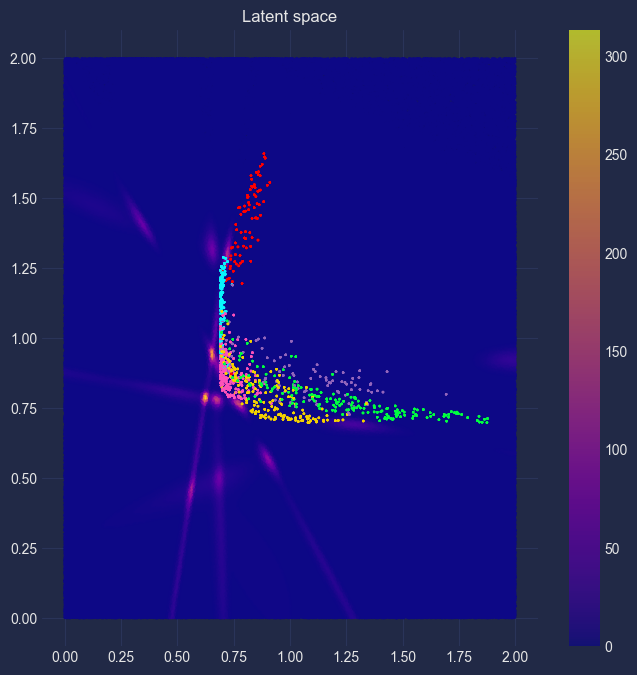

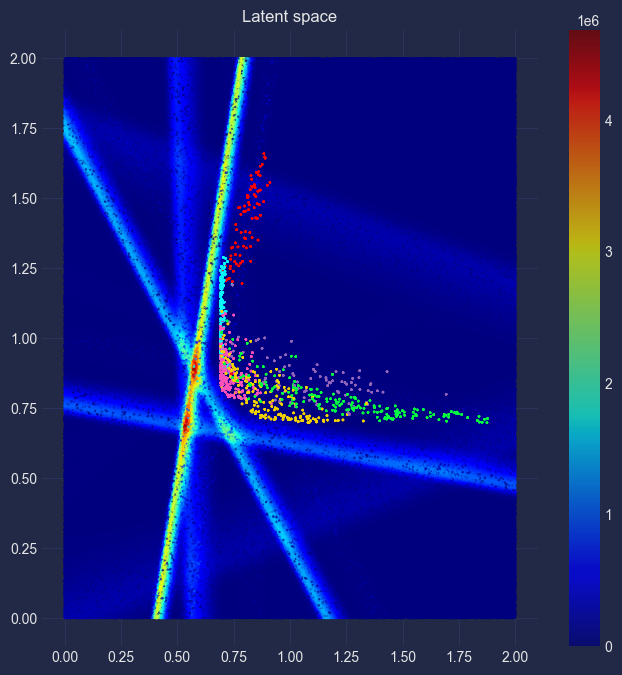

 70%|███████   | 70010/100001 [13:37<4:01:34,  2.07it/s]

70000:(beta)=(    0.6084)


 71%|███████   | 71021/100001 [13:47<04:47, 100.66it/s] 

71000:(beta)=(    0.8007)


 72%|███████▏  | 72012/100001 [13:55<04:01, 115.95it/s]

72000:(beta)=(    0.9920)


 73%|███████▎  | 73024/100001 [14:04<03:47, 118.69it/s]

73000:(beta)=(    0.9082)


 74%|███████▍  | 74018/100001 [14:13<03:42, 117.04it/s]

74000:(beta)=(    0.6694)


 75%|███████▌  | 75015/100001 [14:21<03:31, 118.13it/s]

75000:(beta)=(    0.6177)


 76%|███████▌  | 76018/100001 [14:30<03:32, 112.67it/s]

76000:(beta)=(    0.8272)


 77%|███████▋  | 77022/100001 [14:39<03:13, 118.63it/s]

77000:(beta)=(    0.9977)


 78%|███████▊  | 78021/100001 [14:47<03:12, 114.22it/s]

78000:(beta)=(    0.8849)


 79%|███████▉  | 79023/100001 [14:56<03:01, 115.75it/s]

79000:(beta)=(    0.6505)


 80%|███████▉  | 79995/100001 [15:20<02:54, 114.67it/s]

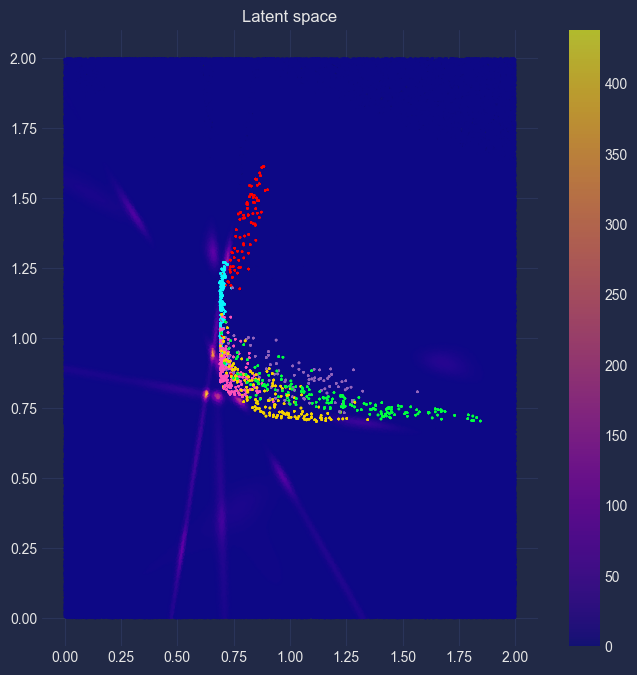

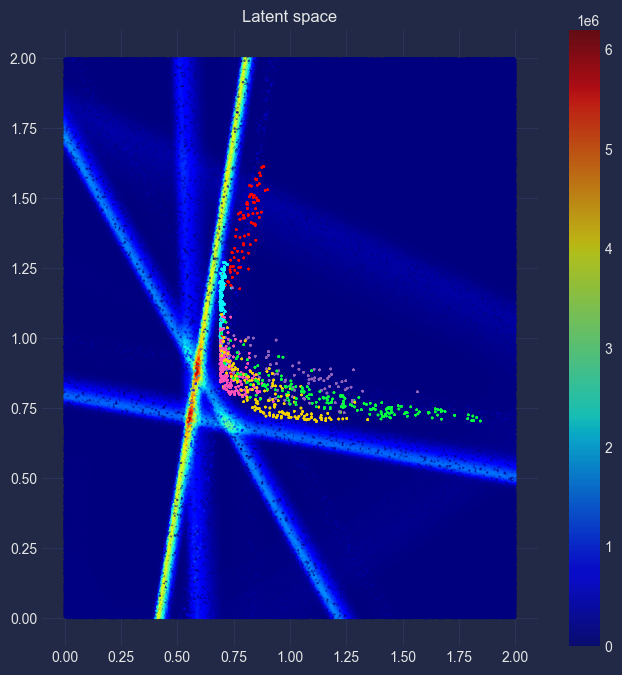

 80%|████████  | 80012/100001 [15:27<2:35:01,  2.15it/s]

80000:(beta)=(    0.6302)


 81%|████████  | 81013/100001 [15:36<02:44, 115.36it/s] 

81000:(beta)=(    0.8533)


 82%|████████▏ | 82015/100001 [15:45<02:20, 128.01it/s]

82000:(beta)=(    1.0000)


 83%|████████▎ | 83019/100001 [15:53<02:14, 126.02it/s]

83000:(beta)=(    0.8602)


 84%|████████▍ | 84026/100001 [16:01<02:06, 126.01it/s]

84000:(beta)=(    0.6342)


 85%|████████▌ | 85021/100001 [16:09<01:57, 127.83it/s]

85000:(beta)=(    0.6458)


 86%|████████▌ | 86021/100001 [16:17<01:51, 125.82it/s]

86000:(beta)=(    0.8783)


 87%|████████▋ | 87022/100001 [16:25<01:53, 114.64it/s]

87000:(beta)=(    0.9987)


 88%|████████▊ | 88026/100001 [16:34<01:34, 126.17it/s]

88000:(beta)=(    0.8344)


 89%|████████▉ | 89015/100001 [16:42<01:37, 112.37it/s]

89000:(beta)=(    0.6208)


 90%|████████▉ | 89997/100001 [16:51<01:31, 108.77it/s]

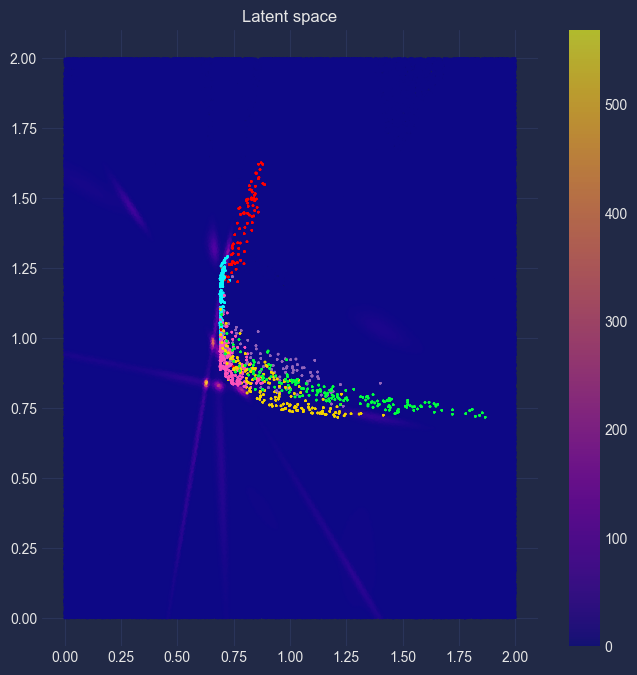

 90%|████████▉ | 89997/100001 [17:10<01:31, 108.77it/s]

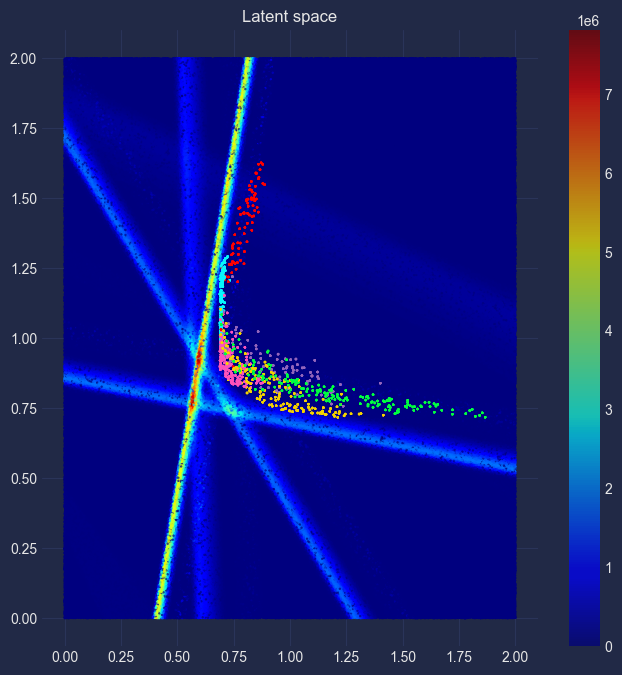

 90%|█████████ | 90011/100001 [17:12<1:18:05,  2.13it/s]

90000:(beta)=(    0.6640)


 91%|█████████ | 91020/100001 [17:21<01:21, 109.87it/s] 

91000:(beta)=(    0.9021)


 92%|█████████▏| 92020/100001 [17:30<01:14, 107.07it/s]

92000:(beta)=(    0.9939)


 93%|█████████▎| 93015/100001 [17:40<01:05, 106.09it/s]

93000:(beta)=(    0.8079)


 94%|█████████▍| 94012/100001 [17:49<00:52, 114.03it/s]

94000:(beta)=(    0.6106)


 95%|█████████▌| 95015/100001 [17:58<00:45, 109.66it/s]

95000:(beta)=(    0.6846)


 96%|█████████▌| 96019/100001 [18:08<00:36, 108.54it/s]

96000:(beta)=(    0.9240)


 97%|█████████▋| 97023/100001 [18:16<00:24, 122.69it/s]

97000:(beta)=(    0.9857)


 98%|█████████▊| 98024/100001 [18:24<00:15, 124.23it/s]

98000:(beta)=(    0.7814)


 99%|█████████▉| 99013/100001 [18:32<00:07, 123.56it/s]

99000:(beta)=(    0.6038)


100%|█████████▉| 99990/100001 [18:40<00:00, 125.62it/s]

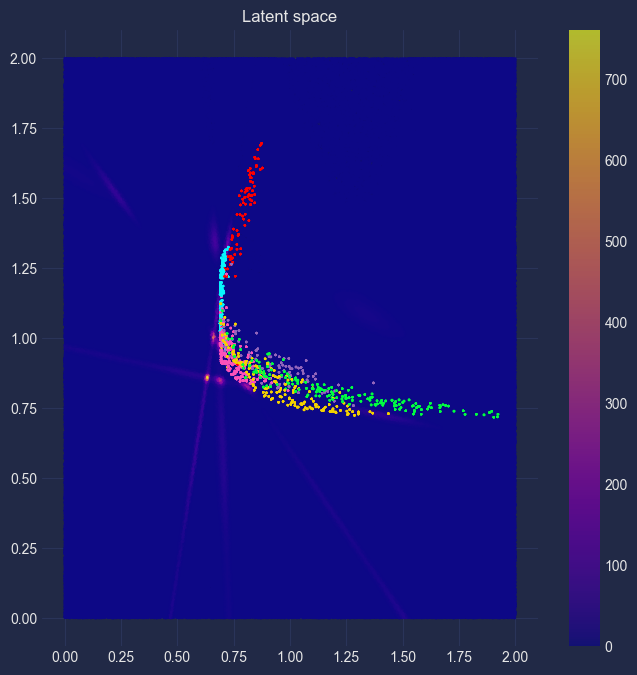

100%|█████████▉| 99990/100001 [19:00<00:00, 125.62it/s]

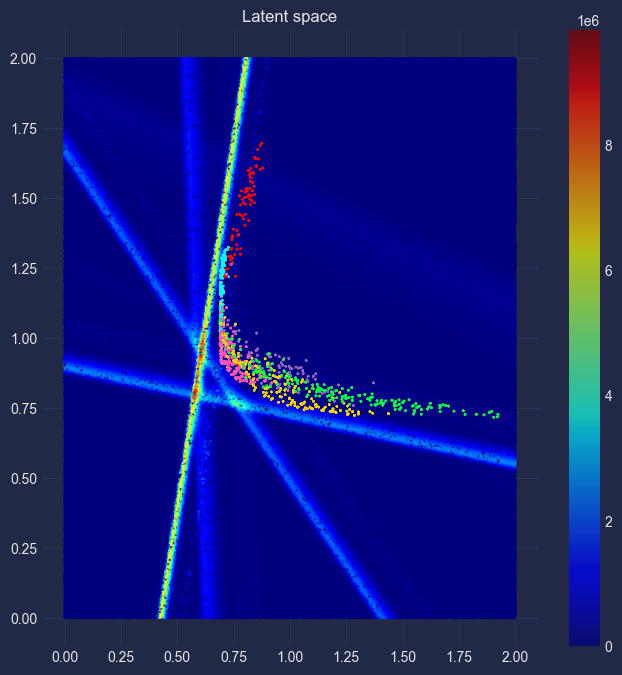

100%|██████████| 100001/100001 [19:01<00:00, 87.57it/s]

100000:(beta)=(    0.7073)


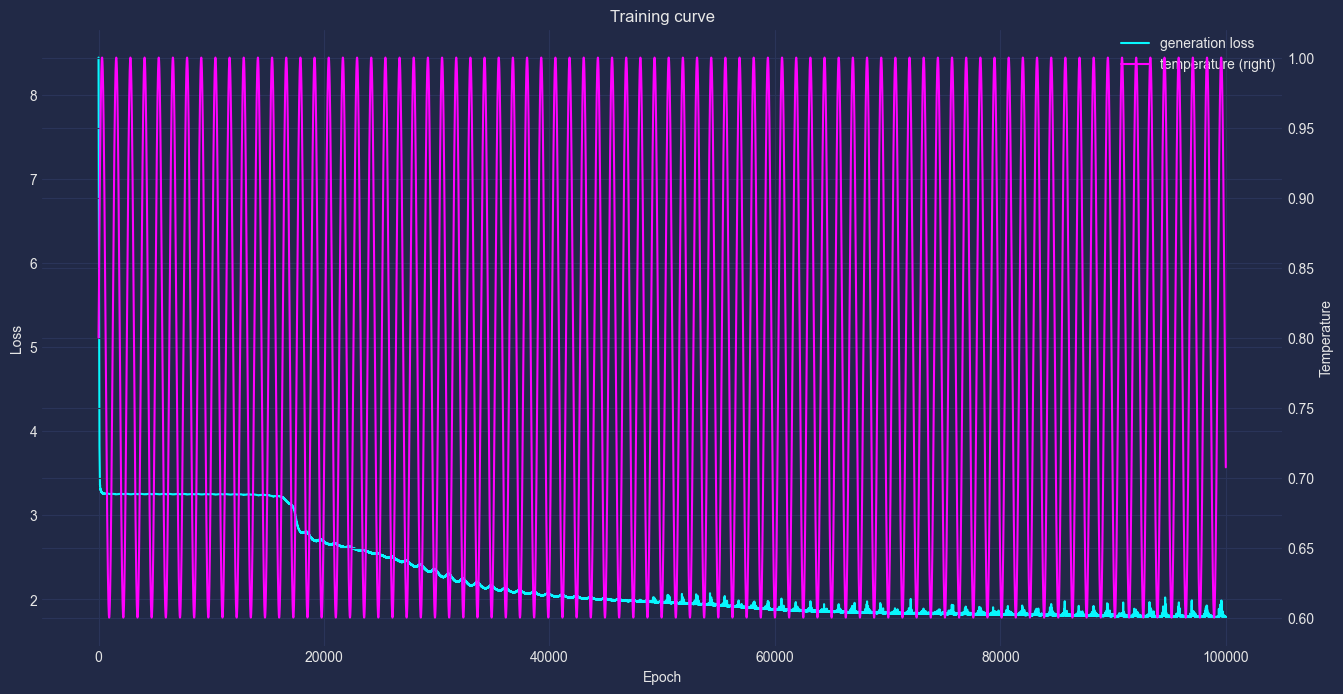

In [4]:
# Optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
#optimizer = optim.Adam(params, lr=5e-5, betas=(0.5, 0.999))
optimizer = optim.SGD(params, lr=1e-3, momentum=0.1)

# Training loop
ac_list = []
gen_loss_list = []
val_list = []
val_gen_loss_list = []
beta_list = []
fifs_list = []

beta_min = 1/5   # must be less than 1/2
cyclical_beta = (1 - beta_min) + beta_min * np.sin(500/n_epoch * np.arange(n_epoch))

for j in tqdm(range(n_epoch)):
    optimizer.zero_grad()
    
    loc, scale = encoder(x)
    prior = Normal(torch.zeros_like(loc), torch.ones_like(scale))
    posterior = Normal(loc, scale)
    z_sample = torch.add(loc, scale.pow_(prior.sample()))
    z_sample.requires_grad_(True)
    
    dec = decoder(z_sample)
    dec.requires_grad_(True)
    log_probs = Bernoulli(probs=dec.pow_(cyclical_beta[j])).log_prob(y)
 
    if j % 10000 == 0:
        n_vis = 10
        enc_test = torch.cat([z_sample for i in range(n_vis)], dim=0).detach().numpy()
        enc_test_label = np.tile(yl_train, (n_vis))
        n_vis = 1000
        z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
        decoder_params = dict(decoder.named_parameters())
        mfs = np.hstack([compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)])
        fifs = np.hstack([compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)])

        rcParams['figure.figsize'] = 8, 8
        plt.figure()
        plt.scatter(z_range[:, 0], z_range[:, 1],
                    #c=mfs, cmap=plt.cm.Reds,
                    c=mfs, cmap=plt.cm.plasma,
                    edgecolor='none', alpha=0.7, s=3)
        plt.colorbar()
        for i in range(len(np.unique(yl_train))):
            plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                        edgecolor='none', alpha=0.7, s=3)
        plt.title('Latent space')
        plt.show()
        
        rcParams['figure.figsize'] = 8, 8
        plt.figure()
        plt.scatter(z_range[:, 0], z_range[:, 1],
                    #c=fifs, cmap=plt.cm.Greens,
                    c=fifs, cmap=plt.cm.jet,
                    edgecolor='none', alpha=0.7, s=3)
        plt.colorbar()
        for i in range(len(np.unique(yl_train))):
            plt.scatter(enc_test[enc_test_label==i][:, 0], enc_test[enc_test_label==i][:, 1],         
                        edgecolor='none', alpha=0.7, s=3)
        plt.title('Latent space')
        plt.show()


    # Loss functions
    kl_divergence = torch.distributions.kl_divergence(posterior, prior).mean()
    recon_likelihood = log_probs.sum(dim=1).mean()
    gen_loss = torch.sub(kl_divergence, recon_likelihood)
    
    gen_loss.backward(retain_graph=True)
    optimizer.step()

    with torch.no_grad():
        correct = (y.argmax(dim=1) == dec.argmax(dim=1)).float()
        accuracy = correct.mean()
        ac_list.append(accuracy.item())
        gen_loss_list.append(gen_loss.item())
        beta_list.append(cyclical_beta[j])
        
        if j % 1000 == 0:
            print("%5d:(beta)=(%10.4f)" % (j, cyclical_beta[j]))

rcParams['figure.figsize'] = 16, 8
fig, ax1 = plt.subplots() 
ax2 = ax1.twinx()
ax1.plot(np.arange(n_epoch), np.asarray(gen_loss_list), label='generation loss')
#ax1.plot(np.arange(n_epoch), np.asarray(val_gen_loss_list), label='validation generation loss')
ax2.plot(np.arange(n_epoch), np.asarray(beta_list), label='temperature (right)', color='magenta')
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.1)
plt.title('Training curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Temperature')
plt.show()

In [5]:
loc, scale = encoder(x)
z_sample = torch.add(loc, scale.pow_(prior.sample()))
z_sample.requires_grad_(True)
dec = decoder(z_sample)
dec.requires_grad_(True)
jacobian = compute_jacobian(decoder, decoder_params, z_sample)

n_vis = 10
enc_test = torch.cat([z_sample for i in range(n_vis)], dim=0).detach().numpy()
enc_test_label = np.tile(yl_train, (n_vis))
n_vis = 1000
z_range = np.random.uniform(0, 2, size=(batch_size*n_vis, latent_dim))
decoder_params = dict(decoder.named_parameters())
mfs = np.hstack([compute_magnification_factor(compute_jacobian(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True))).detach().numpy() for i in range(n_vis)])
fifs = np.hstack([compute_fisher_information_factor(compute_logprobs(decoder, decoder_params, torch.Tensor(z_range[i*batch_size:(i+1)*batch_size]).requires_grad_(True), cyclical_beta, j)).detach().numpy() for i in range(n_vis)])

print(mfs.shape)
print(z_range[:, 0].shape)
print(z_range[:, 1].shape)
print(enc_test.shape)
print(enc_test_label.shape)

(898000,)
(898000,)
(898000,)
(8980, 2)
(8980,)


In [6]:
print(enc_test)
print(enc_test_label)

[[0.69765604 0.98570937]
 [0.75367266 1.0413162 ]
 [0.70974946 0.91859925]
 ...
 [1.6080822  0.7471365 ]
 [0.7239219  0.8860514 ]
 [0.8901255  0.8465338 ]]
[0 5 7 ... 3 7 1]


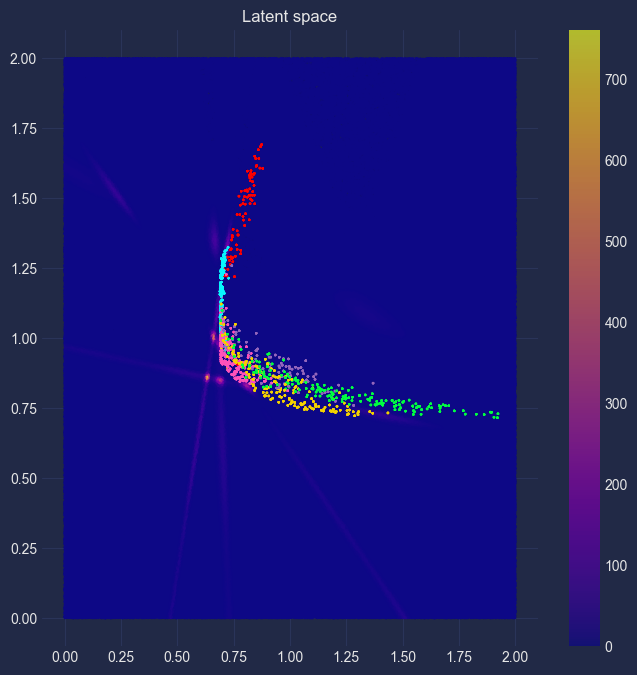

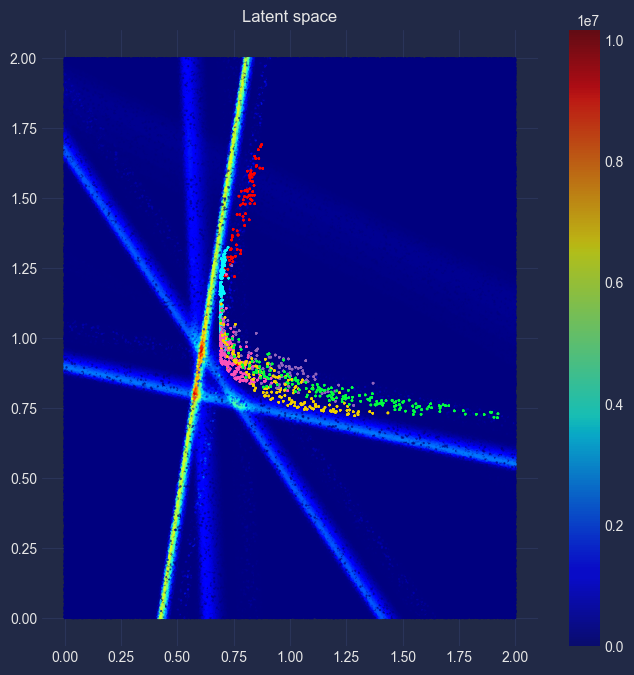

In [7]:
rcParams['figure.figsize'] = 8, 8
plt.figure()
plt.scatter(z_range[:, 0], z_range[:, 1],
            c=mfs, cmap=plt.cm.plasma,
            edgecolor='none', alpha=0.7, s=3)
plt.colorbar()
for i in range(len(np.unique(yl_train))):
    plt.scatter(enc_test[enc_test_label==i, 0], enc_test[enc_test_label==i, 1], 
                edgecolor='none', alpha=0.7, s=3)
plt.title('Latent space')
plt.show()

rcParams['figure.figsize'] = 8, 8
plt.figure()
plt.scatter(z_range[:, 0], z_range[:, 1],
            c=fifs, cmap=plt.cm.jet,
            edgecolor='none', alpha=0.7, s=3)
plt.colorbar()
for i in range(len(np.unique(yl_train))):
    plt.scatter(enc_test[enc_test_label==i][:, 0], enc_test[enc_test_label==i][:, 1],         
                edgecolor='none', alpha=0.7, s=3)
plt.title('Latent space')
plt.show()